In [142]:
import nibabel as nib
import numpy as np
import pandas as pd
from nibabel.processing import resample_from_to
from nilearn.image import resample_to_img  
import matplotlib.pyplot as plt
import skimage as ski
from skimage.measure import label
from skimage.measure import regionprops

In [143]:
# Load the Shirer atlas (4D image)
shirer_img = nib.load('/Users/rachelmorse/Documents/2023:2024/CR & BM Project/Task invariant network/subrois_shirer2012_mod_4d.nii.gz')
shirer_data = shirer_img.get_fdata()

# Load the Task Invariant Network (3D image)
tin_img = nib.load('/Users/rachelmorse/Documents/2023:2024/CR & BM Project/Task invariant network/bothTIN_NART_bag1_Z.nii')
tin_data = tin_img.get_fdata()

# Print shapes to confirm
print(f"Shirer atlas shape: {shirer_data.shape}")
print(f"TIN shape: {tin_data.shape}")

Shirer atlas shape: (91, 109, 91, 90)
TIN shape: (60, 72, 60)


In [144]:
# Resample the Shirer atlas to match the TIN with nearest neighbor interpolation
shirer_resampled_img = resample_to_img(shirer_img, tin_img, interpolation='nearest')
shirer_resampled_data = shirer_resampled_img.get_fdata()

print(f"Resampled Shirer atlas shape: {shirer_resampled_data.shape}")

# Save the resampled Shirer atlas as a NIfTI file
nib.save(shirer_resampled_img, '/Users/rachelmorse/Documents/2023:2024/CR & BM Project/Task invariant network/resampled_shirer.nii')

Resampled Shirer atlas shape: (60, 72, 60, 90)


In [145]:
# Load the MNI image
mni_img = nib.load('/Users/rachelmorse/Documents/2023:2024/CR & BM Project/Task invariant network/mni.nii')
mni_data = mni_img.get_fdata()

# Resample the Shirer atlas to match the TIN with nearest neighbor interpolation
mni_resampled_img = resample_to_img(mni_img, tin_img, interpolation='nearest')
mni_resampled_data = mni_resampled_img.get_fdata()

print(f"Resampled MNI atlas shape: {mni_resampled_data.shape}")

# Save the resampled MNI atlas as a NIfTI file
nib.save(mni_resampled_img, '/Users/rachelmorse/Documents/2023:2024/CR & BM Project/Task invariant network/resampled_mni.nii')

Resampled MNI atlas shape: (60, 72, 60)


In [146]:
# Make a version of the TIN that only contains the values that are > 2 and < -2 (where |Z|>2 and -2<|Z|)

# Mask out values between -2 and 2
modified_data = np.where((tin_data > 2) | (tin_data < -2), tin_data, 0)

# Create a new NIfTI image with the modified data
new_tin_img = nib.Nifti1Image(modified_data, affine=tin_img.affine)

# Save image
nib.save(new_tin_img, '/Users/rachelmorse/Documents/2023:2024/CR & BM Project/Task invariant network/bothTIN_NART_bag1_Z_modified.nii')

In [147]:
# For the purpose of visualization I set negative values = 2 and positive values = 1
# Create a mask of the TIN data
tin_mask = np.zeros_like(tin_data)
tin_mask[tin_data > 2] = 1
tin_mask[tin_data < -2] = -1

# Connectivity=3 because it is a 3D image
clusters = label(tin_mask, connectivity=3)

# Measure the size of each cluster
props = regionprops(clusters)

# Create a mask for clusters larger than 100 voxels
large_cluster_mask = np.zeros_like(clusters)
for prop in props:
    if prop.area > 100:
        large_cluster_mask[clusters == prop.label] = 1

# Apply the mask to the modified data (where |Z|>2 and -2>|Z|) to create new image data
cluster_tin_data = np.zeros_like(tin_mask)
cluster_tin_data[large_cluster_mask == 1] = tin_mask[large_cluster_mask == 1]

# Create a new NIfTI image
cluster_tin_img = nib.Nifti1Image(cluster_tin_data, affine=tin_img.affine)

# Save the new image
nib.save(cluster_tin_img, '/Users/rachelmorse/Documents/2023:2024/CR & BM Project/Task invariant network/bothTIN_NART_bag1_Z_modified_clusters_100.nii')

In [148]:
# Determine the overlap between Shirer and TIN ROIs

# Initialize dictionaries to store results
roi_pos_percentages = {}
roi_neg_percentages = {}
original_voxel_counts = {}
resampled_voxel_counts = {}

num_rois = shirer_data.shape[3]
for roi_index in range(num_rois):
    # Extract the 3D volume for the current ROI before resampling
    roi_mask_original = shirer_data[:, :, :, roi_index]
    original_num_voxels = np.sum(roi_mask_original > 0)
    print(f"ROI_{roi_index}: {original_num_voxels} voxels")

    # Store the original voxel count
    original_voxel_counts[f'ROI_{roi_index}'] = original_num_voxels

    # Extract the 3D volume for the current ROI after resampling
    roi_mask_resampled = shirer_resampled_data[:, :, :, roi_index]
    resampled_num_voxels = np.sum(roi_mask_resampled > 0)
    print(f"Resampled ROI_{roi_index}: {resampled_num_voxels} voxels")

    # Store the resampled voxel count
    resampled_voxel_counts[f'ROI_{roi_index}'] = resampled_num_voxels

    if resampled_num_voxels == 0:
        continue

    # Find how many of the resampled voxels overlap within the task invariant network (positive values)
    overlap_pos_voxels = (roi_mask_resampled > 0) & (cluster_tin_data > 0)
    num_voxels_in_pos_tin = np.sum(overlap_pos_voxels)

    # Find how many of these voxels overlap within the task invariant network (negative values)
    overlap_neg_voxels = (roi_mask_resampled > 0) & (cluster_tin_data < 0)
    num_voxels_in_neg_tin = np.sum(overlap_neg_voxels)

    # Calculate the percentage of ROI voxels in the task invariant network (positive values)
    percentage_in_pos_tin = (num_voxels_in_pos_tin / resampled_num_voxels) * 100
    print(f"ROI_{roi_index} percentage of voxels in positive TIN: {percentage_in_pos_tin:.2f}%")
    
    # Calculate the percentage of ROI voxels in the task invariant network (negative values)
    percentage_in_neg_tin = (num_voxels_in_neg_tin / resampled_num_voxels) * 100
    print(f"ROI_{roi_index} percentage of voxels in negative TIN: {percentage_in_neg_tin:.2f}%")
   
    # Store the result
    roi_pos_percentages[f'ROI_{roi_index}'] = percentage_in_pos_tin
    roi_neg_percentages[f'ROI_{roi_index}'] = percentage_in_neg_tin

ROI_0: 651 voxels
Resampled ROI_0: 181 voxels
ROI_0 percentage of voxels in positive TIN: 0.00%
ROI_0 percentage of voxels in negative TIN: 7.73%
ROI_1: 305 voxels
Resampled ROI_1: 98 voxels
ROI_1 percentage of voxels in positive TIN: 0.00%
ROI_1 percentage of voxels in negative TIN: 77.55%
ROI_2: 2887 voxels
Resampled ROI_2: 866 voxels
ROI_2 percentage of voxels in positive TIN: 0.00%
ROI_2 percentage of voxels in negative TIN: 34.18%
ROI_3: 470 voxels
Resampled ROI_3: 142 voxels
ROI_3 percentage of voxels in positive TIN: 0.00%
ROI_3 percentage of voxels in negative TIN: 4.93%
ROI_4: 319 voxels
Resampled ROI_4: 101 voxels
ROI_4 percentage of voxels in positive TIN: 0.00%
ROI_4 percentage of voxels in negative TIN: 59.41%
ROI_5: 95 voxels
Resampled ROI_5: 27 voxels
ROI_5 percentage of voxels in positive TIN: 51.85%
ROI_5 percentage of voxels in negative TIN: 0.00%
ROI_6: 139 voxels
Resampled ROI_6: 41 voxels
ROI_6 percentage of voxels in positive TIN: 14.63%
ROI_6 percentage of voxels

In [149]:
# Combine the results into a single dictionary
combined_results = {
    'ROI': list(roi_pos_percentages.keys()), # the regions are the same for both pos and neg
    'Percentage Positive': list(roi_pos_percentages.values()),
    'Percentage Negative': list(roi_neg_percentages.values())

}
# Convert the dictionary to a df
results_df = pd.DataFrame(combined_results)

# Specify the path to save a CSV 
output_path = '/Users/rachelmorse/Documents/2023:2024/CR & BM Project/Task invariant network/roi_percentages.csv'

# Save the df 
results_df.to_csv(output_path, index=False)

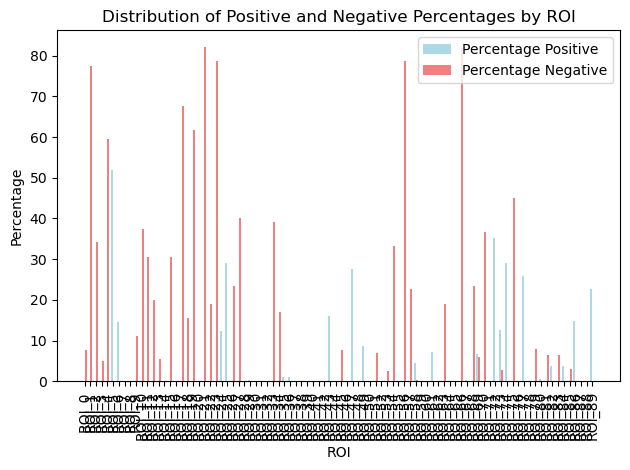

In [150]:
# Visualization the distribution of percentages by ROI
bar_width = 0.35
index = np.arange(len(results_df['ROI']))

# Plotting Percentage Positive
plt.bar(index, results_df['Percentage Positive'], bar_width, color='lightblue', label='Percentage Positive')

# Plotting Percentage Negative 
plt.bar(index + bar_width, results_df['Percentage Negative'], bar_width, color='lightcoral', label='Percentage Negative')

plt.xlabel('ROI')
plt.ylabel('Percentage')
plt.title('Distribution of Positive and Negative Percentages by ROI')
plt.xticks(index + bar_width / 2, results_df['ROI'], rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

No common ROIs found.


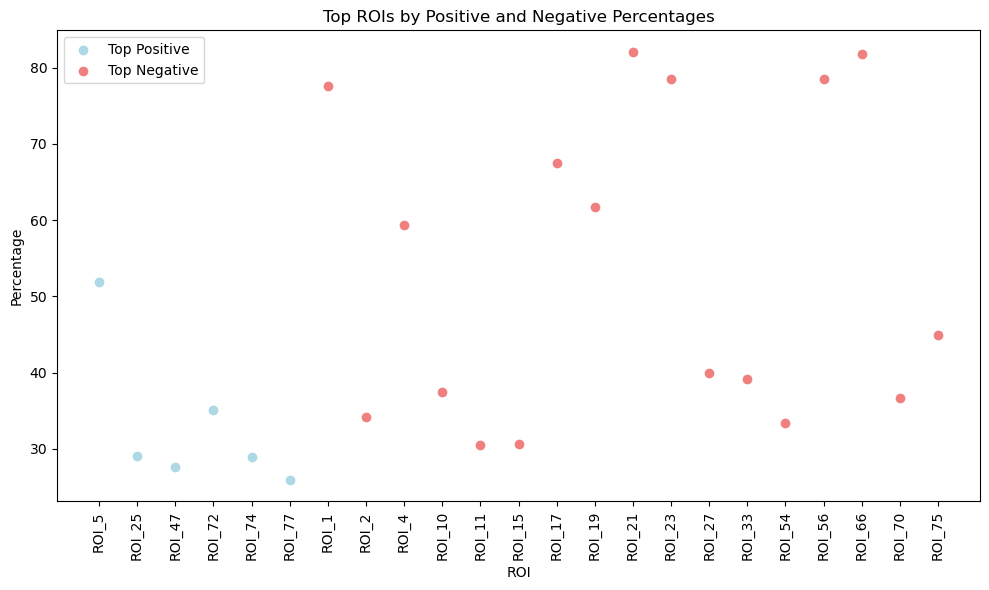

In [151]:
# Define n as the minimum percentage
n = 25

# Identify top ROIs for positive percentages from the df
top_positive = results_df[results_df['Percentage Positive'] > n]

# Identify top ROIs for negative percentages from the df
top_negative = results_df[results_df['Percentage Negative'] > n]

# Find common ROIs between top positive and top negative (to consider whether any ROIs are in both the positive and negative TIN)
common_rois = pd.merge(top_positive, top_negative, on='ROI', how='inner', suffixes=('_pos', '_neg'))

# Display common ROIs, if any
if not common_rois.empty:
    print("Common ROIs with high positive and negative percentages:")
    print(common_rois[['ROI']])
else:
    print("No common ROIs found.")

# Scatter plot of which ROIs are in each TIN and their corresponding percentage overlap
plt.figure(figsize=(10, 6))

# Plotting top positive ROI percentages
plt.scatter(top_positive['ROI'], top_positive['Percentage Positive'], color='lightblue', label='Top Positive')

# Plotting top negative ROI percentages
plt.scatter(top_negative['ROI'], top_negative['Percentage Negative'], color='lightcoral', label='Top Negative')

plt.xlabel('ROI')
plt.ylabel('Percentage')
plt.title('Top ROIs by Positive and Negative Percentages')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

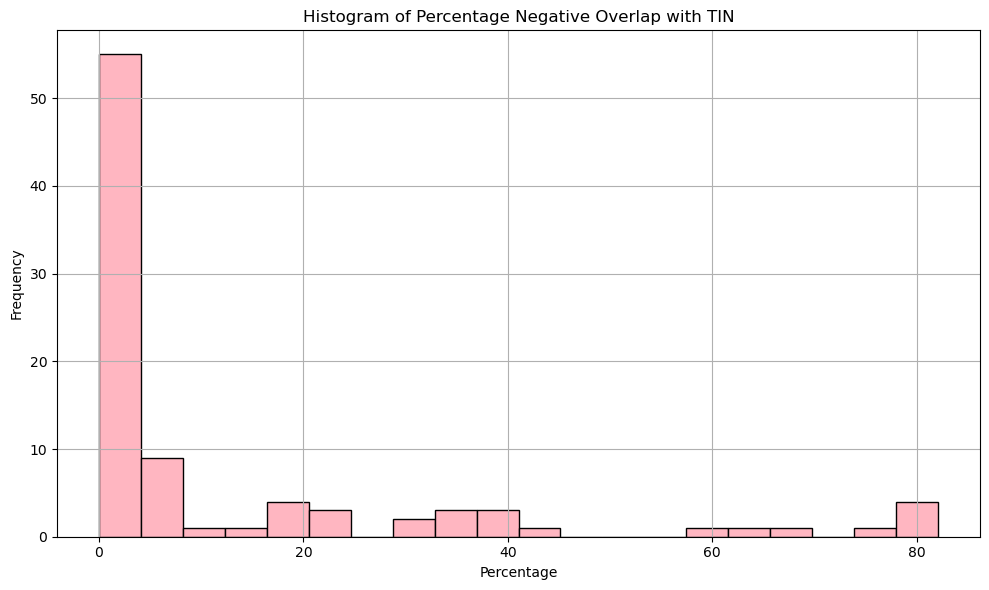

In [152]:
# Visualization histogram of percentages for ROIs in the TIN
plt.figure(figsize=(10, 6))
plt.hist(results_df['Percentage Negative'], bins=20, color='lightpink', edgecolor='black')
plt.xlabel('Percentage')
plt.ylabel('Frequency')
plt.title('Histogram of Percentage Negative Overlap with TIN')
plt.grid(True)
plt.tight_layout()
plt.show()

# plt.figure(figsize=(10, 6))
# plt.hist(results_df['Percentage Positive'], bins=20, color='lightpink', edgecolor='black')
# plt.xlabel('Percentage')
# plt.ylabel('Frequency')
# plt.title('Histogram of Percentage Positive Overlap with TIN')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [153]:
# Drop the str from ROI for merge
top_negative['ROI'] = top_negative['ROI'].str.replace('ROI_', '')
top_positive['ROI'] = top_positive['ROI'].str.replace('ROI_', '')

top_positive.head()

/var/folders/bw/p3l5h82n55n10v29s6vm61qr0000gn/T/ipykernel_42817/2632509750.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_negative['ROI'] = top_negative['ROI'].str.replace('ROI_', '')
/var/folders/bw/p3l5h82n55n10v29s6vm61qr0000gn/T/ipykernel_42817/2632509750.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_positive['ROI'] = top_positive['ROI'].str.replace('ROI_', '')


,ROI,Percentage Positive,Percentage Negative
5,5,51.851852,0.0
25,25,29.076621,0.0
47,47,27.586207,0.0
72,72,35.135135,0.0
74,74,28.970332,0.0


In [154]:
# Load the CSV with the names of the Shirer atlas ROIs
roi_names_df = pd.read_excel('/Users/rachelmorse/Documents/2023:2024/CR & BM Project/Task invariant network/Shirer atlas.xlsx')  

roi_names_df.head()

,ROI,ROI_full_name,ROI_network,ROI_hemisphere,ROI_name,X,Y,Z
0,0,AS_L_midFront,AS,L,midFront,-31.370200,46.691244,22.218126
1,1,AS_L_ins,AS,L,ins,-41.554098,14.157377,-3.068852
2,2,AS_RL_acc_medPref_sma,AS,RL,acc,0.187738,17.290613,46.893661
3,3,AS_R_midFront,AS,R,midFront,28.357447,46.042553,26.395745
4,4,AS_R_ins,AS,R,ins,42.551724,15.084639,-1.404389


In [155]:
# Convert the 'ROI' column in both dfs to string before merging
top_negative['ROI'] = top_negative['ROI'].astype(str)
roi_names_df['ROI'] = roi_names_df['ROI'].astype(str)

# Now merge
top_negative_merged = pd.merge(top_negative, roi_names_df, on='ROI')

# Repeat the process for positve TIN
top_positive['ROI'] = top_positive['ROI'].astype(str)
top_positive_merged = pd.merge(top_positive, roi_names_df, on='ROI')

top_negative_merged.head()

top_negative

/var/folders/bw/p3l5h82n55n10v29s6vm61qr0000gn/T/ipykernel_42817/993015241.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_negative['ROI'] = top_negative['ROI'].astype(str)
/var/folders/bw/p3l5h82n55n10v29s6vm61qr0000gn/T/ipykernel_42817/993015241.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_positive['ROI'] = top_positive['ROI'].astype(str)


,ROI,Percentage Positive,Percentage Negative
1,1,0.0,77.551020
2,2,0.0,34.180139
4,4,0.0,59.405941
10,10,0.0,37.500000
11,11,0.0,30.541872
15,15,0.0,30.651341
17,17,0.0,67.500000
19,19,0.0,61.764706
21,21,0.0,82.089552
23,23,0.0,78.571429


In [156]:
# Subset to only include 'ROI_full_name' 
top_positive_subset = top_positive_merged[['ROI_full_name']]
top_negative_subset = top_negative_merged[['ROI_full_name']]

# Define the path for saving files
base_path = '/Users/rachelmorse/Documents/2023:2024/CR & BM Project/Task invariant network/'

# Save each subset df as CSV 
top_positive_subset.to_csv(base_path + 'top_positive_ROI_full_name_25.csv', index=False)
top_negative_subset.to_csv(base_path + 'top_negative_ROI_full_name_25.csv', index=False)

In [157]:
# Combine the ROI indices from both pos and neg dfs
combined_rois = pd.concat([top_positive['ROI'], top_negative['ROI']]).unique()

# Remove the str "ROI_" 
roi_indices = [int(roi.replace('ROI_', '')) for roi in combined_rois] 

# Select the corresponding volumes for the ROIs
tin_rois_shirer = shirer_resampled_img.get_fdata()[:, :, :, roi_indices]

# Combine all ROIs into one 3D image
combined_roi_volume = np.mean(tin_rois_shirer, axis=3)

# Create new 3D image with combined ROIs
combined_roi_img = nib.Nifti1Image(combined_roi_volume, affine=shirer_resampled_img.affine)

# Save the new 3D image
nib.save(combined_roi_img, '/Users/rachelmorse/Documents/2023:2024/CR & BM Project/Task invariant network/tin_rois_shirer.nii')

# Create 4D version
tin_rois_shirer_img = nib.Nifti1Image(tin_rois_shirer, affine=shirer_resampled_img.affine)

# Save the 4D version
nib.save(tin_rois_shirer_img, '/Users/rachelmorse/Documents/2023:2024/CR & BM Project/Task invariant network/tin_rois_shirer_4d.nii')

In [158]:
# Create a version of the image with negative and positive values labeled differently 
# For the purpose of visualization I set negative values = 2 and positive values = 1

# Initialize the mask with zeros
mask_shape = shirer_resampled_img.shape[:3]
mask = np.zeros(mask_shape)

# Assign 1 to the positive ROIs
for pos_roi in top_positive['ROI']:
    roi_index = int(pos_roi.replace('ROI_', ''))
    mask[tin_rois_shirer[..., roi_indices.index(roi_index)] > 0] = 1

# Assign -1 to the negative ROIs
for neg_roi in top_negative['ROI']:
    roi_index = int(neg_roi.replace('ROI_', ''))
    mask[tin_rois_shirer[..., roi_indices.index(roi_index)] > 0] = 2

# Create a Nifti1Image for the mask
mask_img = nib.Nifti1Image(mask, affine=shirer_resampled_img.affine)

# Save the mask image
nib.save(mask_img, '/Users/rachelmorse/Documents/2023:2024/CR & BM Project/Task invariant network/tin_rois_shirer_mask.nii')

In [159]:
# For the purpose of visualization I set negative values = 2 and positive values = 1
# Create a mask of the TIN data
tin_mask_2 = np.zeros_like(tin_data)
tin_mask_2[tin_data > 2] = 1
tin_mask_2[tin_data < -2] = 2

# Connectivity=3 because it is a 3D image
clusters_2 = label(tin_mask_2, connectivity=3)

# Measure the size of each cluster
props = regionprops(clusters_2)

# Create a mask for clusters larger than 100 voxels
large_cluster_mask_2 = np.zeros_like(clusters_2)
for prop in props:
    if prop.area > 100:
        large_cluster_mask[clusters_2 == prop.label] = 1

# Apply the mask to the modified data (where |Z|>2 and -2<|Z|) to create new image data
cluster_tin_data_2 = np.zeros_like(tin_mask)
cluster_tin_data_2[large_cluster_mask_2 == 1] = tin_mask_2[large_cluster_mask_2 == 1]

# Create a new NIfTI image
cluster_tin_img_2 = nib.Nifti1Image(cluster_tin_data_2, affine=tin_img.affine)

# Save the new image
nib.save(cluster_tin_img_2, '/Users/rachelmorse/Documents/2023:2024/CR & BM Project/Task invariant network/bothTIN_NART_bag1_Z_modified_clusters_100_no_neg.nii')